In [1]:
%cd ..

/Users/larremoreadmin/Library/CloudStorage/OneDrive-UCB-O365/classes/InfectiousDiseases


In [3]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from scipy.stats import nbinom
from tqdm import tqdm


from dynamics import *
from sir_models import *

ModuleNotFoundError: No module named 'dynamics'

In [38]:
N = 4000
gamma = np.ones(4) * 3
cbar = 9 / 8
pC = np.diag([1, 2, 3, 4]) * cbar
x0 = np.zeros(12)
x0[:4] = 0.999
x0[4:8] = 0.001

In [39]:
x0

array([0.999, 0.999, 0.999, 0.999, 0.001, 0.001, 0.001, 0.001, 0.   ,
       0.   , 0.   , 0.   ])

In [47]:
params = {
    "gamma": gamma,
    "pC": pC,
    "omega": np.ones(4) / 4,
}
results, timesteps = forward_euler(sir_multigroup, params, x0, delta_t=0.01, n=1000)

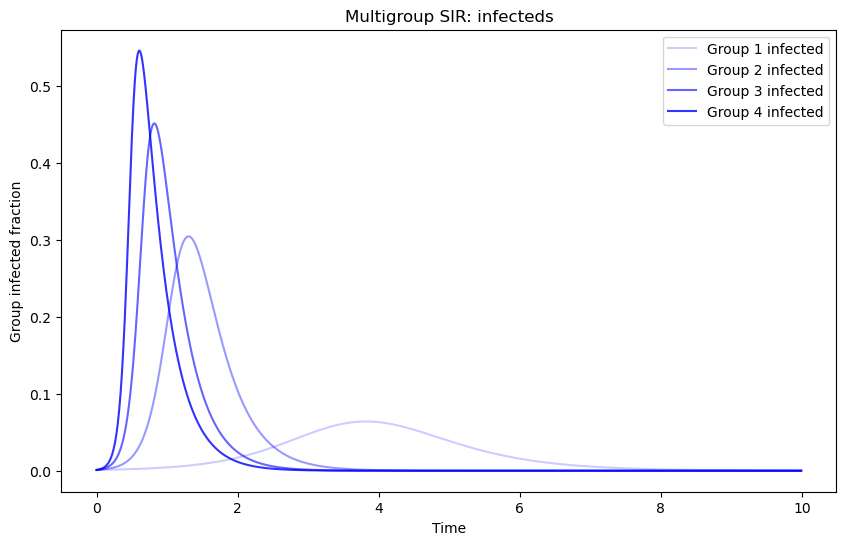

In [57]:
plt.figure(figsize=(10, 6))
for i in range(4):
    plt.plot(
        timesteps,
        results[i + 4, :],
        label=f"Group {i+1} infected",
        color="b",
        alpha=0.2 + 0.2 * i,
    )
plt.legend()
plt.ylabel("Group infected fraction")
plt.xlabel("Time")
plt.title("Multigroup SIR: infecteds")
plt.savefig("hw3/plots/1c.png")

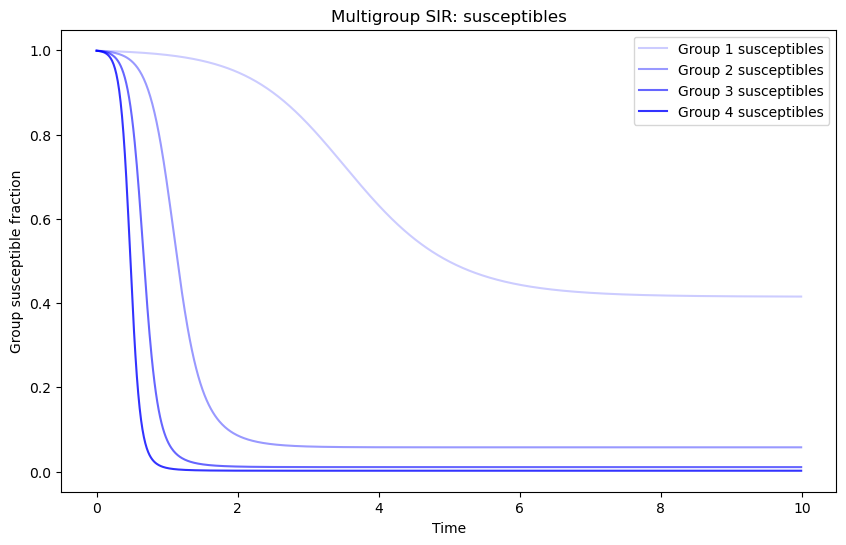

In [58]:
plt.figure(figsize=(10, 6))
for i in range(4):
    plt.plot(
        timesteps,
        results[i, :],
        label=f"Group {i+1} susceptibles",
        color="b",
        alpha=0.2 + 0.2 * i,
    )
plt.legend()
plt.ylabel("Group susceptible fraction")
plt.xlabel("Time")
plt.title("Multigroup SIR: susceptibles")
plt.savefig("hw3/plots/1d_susceptibles.png")

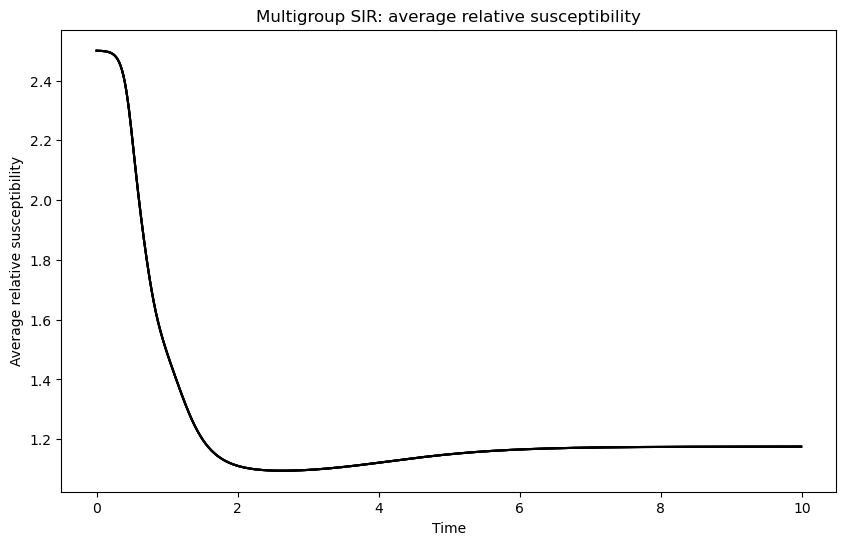

In [64]:
plt.figure(figsize=(10, 6))
p_bar = (np.array([1, 2, 3, 4]) @ results[:4, :]) / (np.ones(4) @ results[:4, :])
for i in range(4):
    plt.plot(
        timesteps,
        p_bar,
        color="k"
    )
plt.ylabel("Average relative susceptibility")
plt.xlabel("Time")
plt.title("Multigroup SIR: average relative susceptibility")
plt.savefig("hw3/plots/1d_avg_susceptibility.png")

# 2.

In [5]:
def branch(size, k, R0):
    mean = R0
    variance = mean + (mean**2)/k
    p = mean/variance
    n = mean**2 / (variance - mean)
    draws = nbinom.rvs(n=n,p=p,size=size)
    return draws.sum()

In [19]:
def will_never_die(size, k, R0, epsilon=1e-10):
    """
    Check if the probability that the sum of 'size' NegBin draws is less than 'size' 
    is below epsilon, indicating the branching process will almost certainly grow.
    """
    p = k / (k + R0)  # success probability
    n = k  # number of successes for single draw
    n_sum = size * n
    
    # P(Sum < size) = P(Sum <= size - 1)
    prob_sum_less_than_size = nbinom.cdf(size - 1, n_sum, p)
    
    return prob_sum_less_than_size < epsilon

In [20]:
k = 10
R0 = 3

print(f"Testing with k={k}, R0={R0}\n")
print(f"{'size':<8} {'will_never_die':<18} {'P(sum < size)':<15}")
print("-" * 45)

for size in [1, 5, 10, 50, 100, 500]:
    result = will_never_die(size, k, R0, epsilon=1e-10)
    p = k / (k + R0)
    n_sum = size * k
    prob = nbinom.cdf(size - 1, n_sum, p)
    print(f"{size:<8} {str(result):<18} {prob:.2e}")

Testing with k=10, R0=3

size     will_never_die     P(sum < size)  
---------------------------------------------
1        False              7.25e-02
5        False              2.37e-03
10       False              4.46e-05
50       True               3.08e-18
100      True               1.98e-34
500      True               3.76e-163


In [21]:
n_reps = 1000
ks = [0.1, 0.5, 1, 5, 10]
bp_finite = []
max_gen = 10000
R0 = 3
for k in ks: 
    n_died = 0
    for _ in tqdm(range(n_reps)):
        n_infected = 1
        gen = 0
        for gen in range(max_gen):
            if n_infected == 0:
                n_died += 1
                break
            if not will_never_die(n_infected, k, R0):
                n_infected = branch(n_infected, k, R0)
            else:
                break
    bp_finite.append(n_died / n_reps)


100%|██████████| 1000/1000 [00:00<00:00, 3883.54it/s]


In [22]:
bp_finite

[0.856, 0.493, 0.327, 0.125, 0.097]

In [23]:
n_outbreaks = 100_000
ks = [0.1, 1, 5]
outbreak_sizes = {k: [] for k in ks}
max_gen = 10000
R0 = 3
for k in ks: 
    n_finite = 0
    while n_finite < 100000:
        n_infected = 1
        size = n_infected
        for gen in range(max_gen):
            if n_infected == 0:
                outbreak_sizes[k].append(size)
                n_finite += 1
                break
            if not will_never_die(n_infected, k, R0):
                n_infected = branch(n_infected, k, R0)
                size += n_infected
            else:
                break

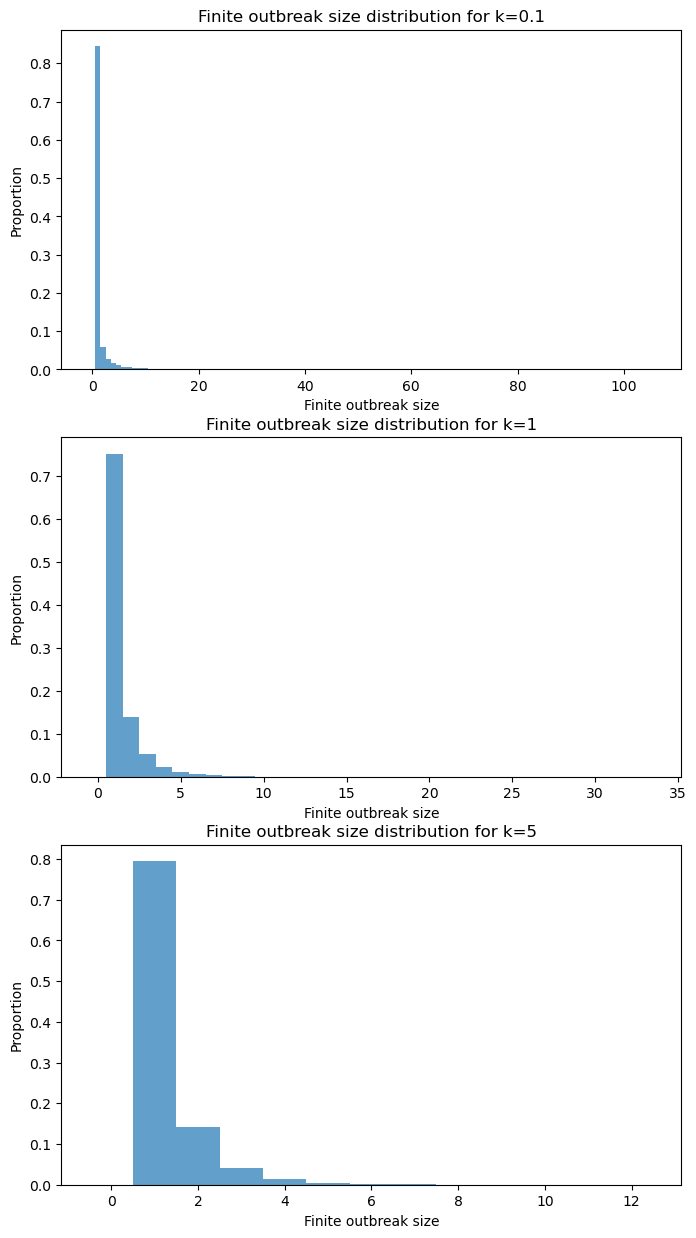

In [25]:
fig, axs = plt.subplots(len(ks), 1, figsize=(8, 5 * len(ks)))
for i, k in enumerate(ks):
    axs[i].hist(
        outbreak_sizes[k],
        bins=np.arange(0, max(outbreak_sizes[k]) + 1) - 0.5,
        density=True,
        alpha=0.7,
    )
    axs[i].set_title(f"Finite outbreak size distribution for k={k}")
    axs[i].set_xlabel("Finite outbreak size")
    axs[i].set_ylabel("Proportion")
plt.savefig("plots/2ec.png")